## KMeans & KNN

### Import Libraries & Dataset

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

!pip install opendatasets
import opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# username = 'alinourian'
# key = '4200c3f083710c14f67a2dab913f61e6'

opendatasets.download("https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset/u.data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alinourian
Your Kaggle Key: ··········


100%|██████████| 4.77M/4.77M [00:00<00:00, 102MB/s]

In [3]:
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('./movielens-100k-dataset/ml-100k/u.user', sep='|', names=user_columns) 
users_df.head(5)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
movie_columns = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df = pd.read_csv('./movielens-100k-dataset/ml-100k/u.item', sep='|', names=movie_columns, encoding='latin-1') 
movies_df.head(5)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
cluster_movie_df = movies_df.copy()
cluster_movie_df.drop('movie id', inplace=True, axis=1)
cluster_movie_df.drop('movie title', inplace=True, axis=1)
cluster_movie_df.drop('release date', inplace=True,  axis=1)
cluster_movie_df.drop('video release date', inplace=True, axis=1)
cluster_movie_df.drop('IMDb URL', inplace=True, axis=1)
cluster_movie_df.head(5)

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [6]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('./movielens-100k-dataset/ml-100k/u.data', sep='\t', names=ratings_columns)
ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
ratings_df.head(5)

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


### Create Utility Matrix

In [7]:
utility_matrix = ratings_df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
utility_matrix.head(5)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
n = int(0.2 * utility_matrix.shape[1])
print(n)

r = np.random.randint(1, utility_matrix.shape[1], n)

train_utility_matrix_df = utility_matrix.copy()
test_utility_matrix_df = utility_matrix.copy()
train_utility_matrix_df.iloc[:, r] = 0

336


### WCSS

In [9]:
wcss = []
clusters = range(2, 100, 5)
for i in tqdm(clusters):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(cluster_movie_df)
    # prediction = kmeans.predict(cluster_movie_df)
    wcss.append(kmeans.inertia_)
wcss

  0%|          | 0/20 [00:00<?, ?it/s]

[1846.6868982225337,
 1100.714076289362,
 835.2890046346678,
 676.4974640833799,
 571.7271968820812,
 505.2319118874743,
 439.4256450007408,
 398.59495624670114,
 359.39948113733783,
 324.46318676419196,
 295.9084028423111,
 271.89248457410775,
 246.68544521696762,
 227.47316878817873,
 208.1050331047191,
 191.0601694715981,
 174.2250575612646,
 163.25252897095947,
 152.4581693655329,
 138.0924239105937]

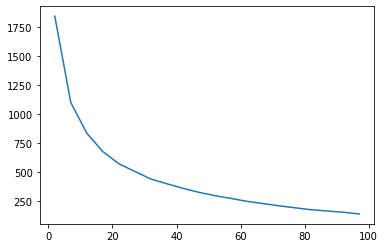

In [10]:
plt.plot(clusters, wcss)

### Create Utility Clustered Matrix

In [11]:
n_clusters = 80
n_users = len(train_utility_matrix_df.index)

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(cluster_movie_df)
prediction = kmeans.predict(cluster_movie_df)

In [12]:
X = np.zeros((n_users, n_clusters))

for i in tqdm(range(n_users)):
    clusters = np.zeros((n_clusters,))
    df = train_utility_matrix_df.iloc[i]
    df = df[df != 0]
    movies_index = df.index
    for index in movies_index:
        pred = prediction[index-1]
        clusters[pred] += 1
    X[i, :] = clusters

utility_clustered_matrix = pd.DataFrame(X, columns=range(n_clusters), index=utility_matrix.index)

  0%|          | 0/943 [00:00<?, ?it/s]

In [13]:
utility_clustered_matrix

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
user_id,,,,,,,,,,,,,,,,,,,,,
1,9.0,31.0,1.0,21.0,9.0,5.0,3.0,4.0,8.0,3.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,13.0,1.0,7.0,1.0,1.0,0.0,0.0,7.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,5.0,0.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,9.0,1.0,24.0,11.0,7.0,2.0,0.0,1.0,3.0,...,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,1.0,3.0,0.0,6.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,7.0,10.0,0.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
941,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate People Correlations (Similarity Matrix)

sample of 30 people:


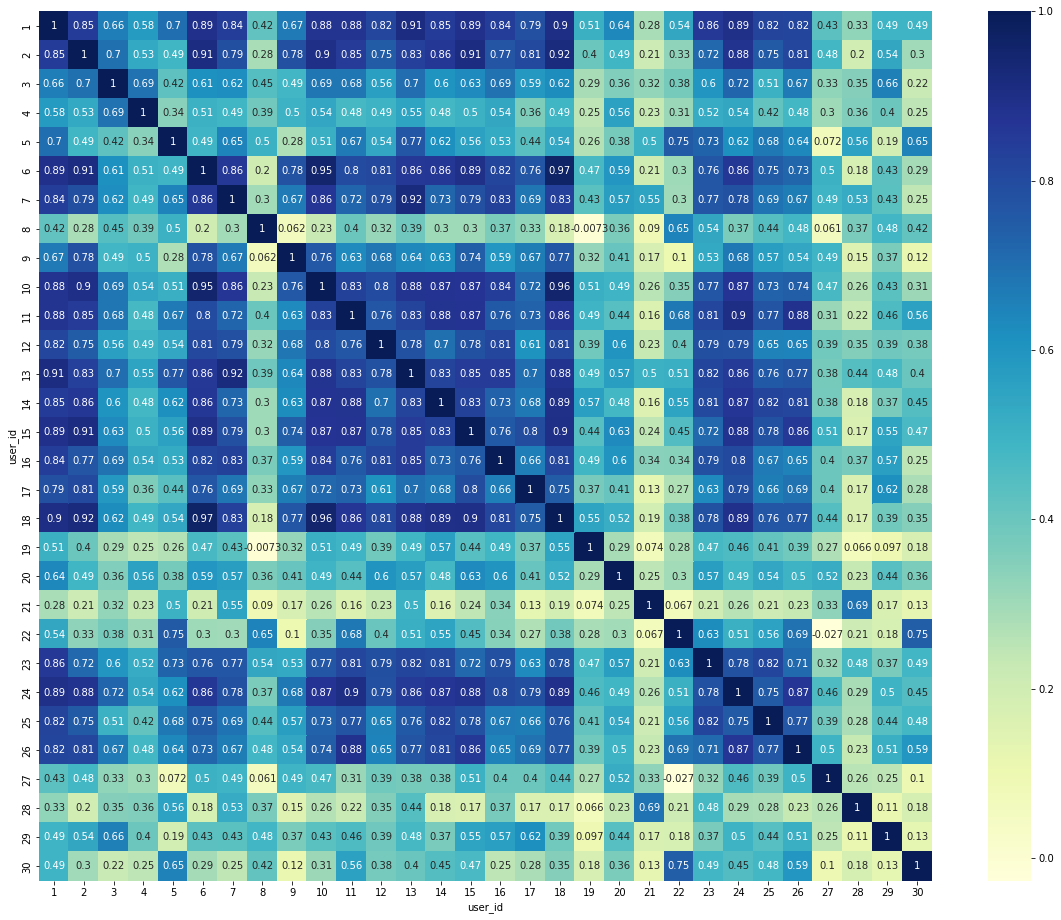

In [14]:
plt.subplots(figsize=(20, 16))
similarity_matrix = utility_clustered_matrix.T.corr()

print(f'sample of 30 people:')
sns.heatmap(similarity_matrix.iloc[:30, :30], cmap="YlGnBu", annot=True)
plt.show()

### Predict

In [15]:
def knn(user_id, top_n=10, similarity_matrix=similarity_matrix):
    x = similarity_matrix.loc[user_id]
    x = x.sort_values(ascending=False)
    return x[1:top_n]

def gess(user_id, top_n_users=10, utility_matrix=train_utility_matrix_df):
    same_users = knn(user_id, top_n_users)
    temp_df = utility_matrix.loc[same_users.index]
    movies_id = temp_df[temp_df == 5].index
    return movies_id.values

In [16]:
top_n = 10
movies_id = gess(user_id=1, top_n_users=top_n)

print(f'Recommended movies from top-{top_n} similar users:\n{movies_id}')

Recommended movies from top-10 similar users:
[457  94 378 916 429 293 450 373 327]


### Predict for test user

In [31]:
def predict_test_user(user_id, movie_id, utility_matrix=train_utility_matrix_df):
    if train_utility_matrix_df[movie_id].loc[user_id] != 0:
        return train_utility_matrix_df[movie_id].loc[user_id]
    top_n_users = 5
    rate = -1
    while True:
        same_users = knn(user_id, top_n_users)
        rate = 0
        for user in same_users.index:
            local_rate = train_utility_matrix_df[movie_id].loc[user]
            if local_rate != 0:
                rate += local_rate
        rate /= len(same_users.index)
        if rate != 0 and top_n_users > 50:
            break
        top_n_users += 5
    return rate

In [67]:
movies_id = r
samples = []
temp_df = test_utility_matrix_df[movies_id]
for i in range(temp_df.shape[0]):
    for j in range(temp_df.shape[1]):
        if test_utility_matrix_df.iloc[i, j] != 0:
            samples.append((test_utility_matrix_df.index[i], test_utility_matrix_df.columns[j], test_utility_matrix_df.iloc[i, j]))

samples = np.array(samples)
n_sample = 10
samples = samples[np.random.randint(0, len(samples), n_sample)]

In [68]:
for (user_id, movie_id, true_rate) in samples:
    rate = predict_test_user(user_id=user_id, movie_id=movie_id)
    print(f'predicted rate of user {user_id} for movie {movie_id}: {rate}')
    print(f'true rate is: {true_rate}\n')

predicted rate of user 345.0 for movie 226.0: 3.0
true rate is: 3.0

predicted rate of user 710.0 for movie 327.0: 3.0
true rate is: 3.0

predicted rate of user 896.0 for movie 31.0: 3.0
true rate is: 3.0

predicted rate of user 630.0 for movie 222.0: 4.0
true rate is: 4.0

predicted rate of user 796.0 for movie 15.0: 4.0
true rate is: 4.0

predicted rate of user 518.0 for movie 129.0: 5.0
true rate is: 5.0

predicted rate of user 222.0 for movie 96.0: 5.0
true rate is: 5.0

predicted rate of user 268.0 for movie 16.0: 3.0
true rate is: 3.0

predicted rate of user 59.0 for movie 220.0: 2.0
true rate is: 2.0

predicted rate of user 286.0 for movie 139.0: 3.0
true rate is: 3.0

